# Fair Value Gap - Analytics

### Import Library

In [28]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
from candlestick import WHITE_CS, BLACK_CS, DOJI_CS

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [29]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [30]:
data = dataset.copy()

In [31]:
def fvg_modeling(htd):
    """ fair_value_gap """
    data = htd.copy()
    data["oc_dif"] = data.apply(lambda r: r['Close'] - r['Open'], axis=1)
    data['color'] = data.apply(
        lambda r: DOJI_CS if r['oc_dif'] == 0 else (
            WHITE_CS if r['oc_dif'] > 0 else BLACK_CS), axis=1)
    data['color_prev_1'] = data['color'].shift(1)
    data['color_prev_2'] = data['color'].shift(2)
    data['high_prev_2'] = data['High'].shift(2)
    data['low_prev_2'] = data['Low'].shift(2)
    data.dropna(inplace=True)
    data['fvg'] = data.apply(lambda r: cal_fvg(r), axis=1)
    data.drop(columns=['color', 'color_prev_1', 'color_prev_2', 'high_prev_2', 'low_prev_2', 'oc_dif'], inplace=True)
    return data

In [32]:
def cal_fvg(r):
    fvg = ''
    if (r['color_prev_2'] == DOJI_CS or r['color_prev_2'] == WHITE_CS) \
            and r['color_prev_1'] == WHITE_CS and r['color'] == WHITE_CS \
            and r['high_prev_2'] < r['Low'] - 0.1:
        fvg = 'fvg_up'
    elif (r['color_prev_2'] == DOJI_CS or r['color_prev_2'] == BLACK_CS) \
            and r['color_prev_1'] == BLACK_CS and r['color'] == BLACK_CS \
            and r['low_prev_2'] > r['High'] + 0.1:
        fvg = 'fvg_down'
    return fvg

In [33]:
data = fvg_modeling(data)

In [34]:
data['min_3_low'] = data['Low'].rolling(3).min()
data['max_3_high'] = data['High'].rolling(3).max()

In [35]:
TREND_UP = 'up'
TREND_DOWN = 'down'
data["ema_f1"] = ta.ema(data["Close"], length=9)
data["ema_l1"] = ta.ema(data["Close"], length=26)
data["short_trend"] = data.apply(lambda r: TREND_UP if r['ema_f1'] > r['ema_l1'] else TREND_DOWN, axis=1)
data["ema_f2"] = ta.ema(data["Close"], length=16)
data["ema_l2"] = ta.ema(data["Close"], length=250)
data["long_trend"] = data.apply(lambda r: TREND_UP if r['ema_f2'] > r['ema_l2'] else TREND_DOWN, axis=1)
data.drop(columns=['ema_f1', 'ema_l1', 'ema_f2', 'ema_l2'], inplace=True)

In [36]:
data.dropna(inplace=True)

### Calculating return

In [37]:
RR = 3
def cal_return(data):
    data['return'] = ''
    data['exit_time'] = ''
    data['entry_price'] = ''
    data['exit_price'] = ''
    data['deal_type'] = ''
    data['sl_length'] = ''
    data['min_max_length'] = ''
    for i, row in data.iterrows():
        if 910 < 100*row.name.hour + row.name.minute < 1430:
            if row['fvg'] != '':
                _return = 0
                deal_type = ''
                current_date = row.name.strftime('%Y-%m-%d ').format()
                current_time = row.name
                entry_price = max_price = min_price = row['Close']
                data_from_start_day = data[(data.index < current_time) & (data.index > current_date + ' 08:59:00')]
                if 100*row.name.hour + row.name.minute < 1405:
                    if row['fvg'] == 'fvg_up' and row['long_trend'] == 'up':
                        deal_type = 'long'
                        stoploss = row['min_3_low']
                        sl_length = entry_price - stoploss
                        min_max_length = entry_price - data_from_start_day['Low'].min()
                    elif row['fvg'] == 'fvg_down' and row['long_trend'] == 'down':
                        deal_type = 'short'
                        stoploss = row['max_3_high']
                        sl_length = stoploss - entry_price
                        min_max_length = data_from_start_day['High'].max() - entry_price
                exit_time = ''
                exit_price = 0
                data_to_end_day = data[(data.index > current_time) & (data.index < current_date + ' 14:30:00')]
                for k, wrow in data_to_end_day.iterrows():
                    if deal_type == 'long':
                        if wrow['Low'] < stoploss:
                            # if max_price >= entry_price + RR * sl_length:
                            #     # Take profit
                            #     _return = RR * sl_length
                            #     exit_time = wrow.name
                            #     exit_price = entry_price + RR * sl_length
                            # else:
                                # Stoploss
                            if max_price < entry_price + sl_length:
                                # if profit >= stoploss, keep deal as has profit
                                # else do stoploss
                                _return = stoploss - entry_price
                                exit_time = wrow.name
                                exit_price = wrow['Low']
                            else:
                                _return = exit_price - entry_price
                            break
                        else:
                            if wrow['High'] > max_price:
                                max_price = wrow['High']
                                exit_time  = wrow.name
                                exit_price = max_price
                            if 100*row.name.hour + row.name.minute == 1425:
                                _return = exit_price - entry_price
                                break
                    if deal_type == 'short':
                        if wrow['High'] > stoploss:
                            if min_price > entry_price - sl_length:
                                # if profit >= stoploss, keep deal as has profit
                                # else do stoploss
                                _return = entry_price - stoploss
                                exit_time = wrow.name
                                exit_price = stoploss
                            else:
                                _return = entry_price - exit_price
                            break
                        else:
                            if wrow['Low'] < min_price:
                                min_price = wrow['Low']
                                exit_time  = wrow.name
                                exit_price = min_price
                            if 100*row.name.hour + row.name.minute == 1425:
                                _return = entry_price - exit_price
                                break
                if deal_type != '':
                    data.at[i, 'deal_type'] = deal_type
                    data.at[i, 'entry_price'] = entry_price
                    data.at[i, 'return'] = _return
                    data.at[i, 'exit_price'] = exit_price
                    data.at[i, 'exit_time'] = exit_time
                    data.at[i, 'sl_length'] = sl_length
                    data.at[i, 'min_max_length'] = min_max_length
    return data

In [38]:
%%time
data = cal_return(data)

CPU times: user 18.7 s, sys: 7.83 ms, total: 18.7 s
Wall time: 18.7 s


In [39]:
data[data.index > '2024-09-18 08:59:00']

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high,short_trend,long_trend,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,,,
2024-09-18 09:00:00,1305.0,1305.7,1304.0,1304.0,4270,,1300.0,1305.8,up,up,,,,,,,
2024-09-18 09:05:00,1304.5,1305.4,1304.1,1304.8,1994,,1304.0,1305.8,up,up,,,,,,,
2024-09-18 09:10:00,1305.0,1305.2,1304.6,1305.2,895,,1304.0,1305.7,up,up,,,,,,,
2024-09-18 09:15:00,1305.2,1305.4,1304.2,1304.3,2945,,1304.1,1305.4,up,up,,,,,,,
2024-09-18 09:20:00,1304.2,1304.2,1303.2,1303.5,2921,,1303.2,1305.4,up,up,,,,,,,
2024-09-18 09:25:00,1303.5,1304.6,1303.5,1304.2,1447,,1303.2,1305.4,up,up,,,,,,,
2024-09-18 09:30:00,1304.2,1307.5,1303.6,1307.1,4492,,1303.2,1307.5,up,up,,,,,,,
2024-09-18 09:35:00,1307.4,1307.4,1306.1,1306.4,3595,,1303.5,1307.5,up,up,,,,,,,
2024-09-18 09:40:00,1306.4,1307.5,1306.3,1306.6,2583,,1303.6,1307.5,up,up,,,,,,,


In [40]:
has_return = data[(data['return'] != '') & (data['return'] != 0)]

In [41]:
has_return

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high,short_trend,long_trend,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,,,
2018-08-14 10:40:00,953.4,953.7,952.6,952.9,2550,fvg_down,952.6,956.1,up,down,-3.2,2018-08-14 13:15:00,952.9,956.1,short,3.2,4.4
2018-08-14 11:10:00,952.9,953.3,952.1,952.3,1416,fvg_down,952.1,954.4,down,down,-2.1,2018-08-14 11:25:00,952.3,954.4,short,2.1,5.0
2018-08-15 10:10:00,960.3,960.3,959.9,960.1,1250,fvg_down,959.9,961.4,up,down,-1.3,2018-08-15 10:30:00,960.1,961.4,short,1.3,1.4
2018-08-15 13:05:00,956.5,957.0,955.2,955.2,2217,fvg_down,955.2,958.1,down,down,-2.9,2018-08-15 13:50:00,955.2,958.1,short,2.9,7.1
2018-08-16 10:50:00,938.0,938.4,937.1,937.5,2654,fvg_down,937.1,942.3,down,down,-4.8,2018-08-16 13:40:00,937.5,942.3,short,4.8,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-12 11:05:00,1300.6,1300.6,1299.6,1300.1,3262,fvg_down,1299.6,1301.7,up,down,2.0,2024-09-12 11:20:00,1300.1,1298.1,short,1.6,2.0
2024-09-12 11:10:00,1300.2,1300.3,1298.7,1298.8,3954,fvg_down,1298.7,1301.2,up,down,-2.4,2024-09-12 13:45:00,1298.8,1301.2,short,2.4,3.3
2024-09-13 09:40:00,1295.2,1295.4,1294.7,1294.7,5295,fvg_down,1294.7,1298.4,down,down,-3.7,2024-09-13 13:00:00,1294.7,1298.4,short,3.7,5.4


In [42]:
has_return['return'].sum()

-2953.0000000000045

In [43]:
long = has_return[has_return['deal_type'] == 'long']

In [44]:
long.tail(30)

,Open,High,Low,Close,Volume,fvg,min_3_low,max_3_high,short_trend,long_trend,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,,,
2024-07-11 09:40:00,1315.9,1317.1,1315.9,1317.1,6391,fvg_up,1314.1,1317.1,up,up,-3.0,2024-07-11 10:55:00,1317.1,1313.7,long,3.0,3.2
2024-07-11 09:45:00,1317.1,1317.9,1316.5,1317.2,4438,fvg_up,1315.3,1317.9,up,up,-1.9,2024-07-11 10:25:00,1317.2,1315.0,long,1.9,3.3
2024-07-17 13:35:00,1308.5,1312.4,1307.2,1311.3,9142,fvg_up,1303.8,1312.4,up,up,10.5,2024-07-17 14:05:00,1311.3,1321.8,long,7.5,9.6
2024-07-17 13:40:00,1311.6,1314.0,1311.6,1313.0,11462,fvg_up,1306.5,1314.0,up,up,8.8,2024-07-17 14:05:00,1313.0,1321.8,long,6.5,11.3
2024-07-29 09:40:00,1292.4,1293.2,1292.4,1292.9,3915,fvg_up,1291.2,1293.2,up,up,1.8,2024-07-29 09:55:00,1292.9,1294.7,long,1.7,3.0
2024-07-29 09:45:00,1293.0,1294.2,1293.0,1294.1,3893,fvg_up,1291.7,1294.2,up,up,-2.4,2024-07-29 10:45:00,1294.1,1291.5,long,2.4,4.2
2024-07-29 09:50:00,1294.0,1294.4,1293.7,1294.4,2263,fvg_up,1292.4,1294.4,up,up,-2.0,2024-07-29 10:30:00,1294.4,1292.1,long,2.0,4.5
2024-07-29 13:45:00,1292.7,1293.4,1292.7,1292.8,3200,fvg_up,1291.0,1293.4,up,up,-1.8,2024-07-29 14:15:00,1292.8,1290.9,long,1.8,2.9
2024-07-30 11:20:00,1287.2,1288.8,1287.2,1288.8,3974,fvg_up,1286.5,1288.8,up,up,3.6,2024-07-30 13:20:00,1288.8,1292.4,long,2.3,4.6


In [45]:
long['sl_length'] = long['sl_length'].astype(float)

In [46]:
long['sl_group'] = pd.qcut(long.sl_length, 20)

In [47]:
long['min_max_length'] = long['min_max_length'].astype(float)

In [48]:
long['return'] = long['return'].astype(float)

In [49]:
long['min_max_group'] = pd.qcut(long.min_max_length, 20)

In [50]:
long['sl_length'].describe()

count    1128.000000
mean        3.490957
std         2.405876
min         0.500000
25%         1.900000
50%         2.900000
75%         4.300000
max        26.700000
Name: sl_length, dtype: float64

In [51]:
long['return'].describe()

count    1128.000000
mean       -1.569149
std         4.958147
min       -26.700000
25%        -4.100000
50%        -2.500000
75%        -0.900000
max        39.200000
Name: return, dtype: float64

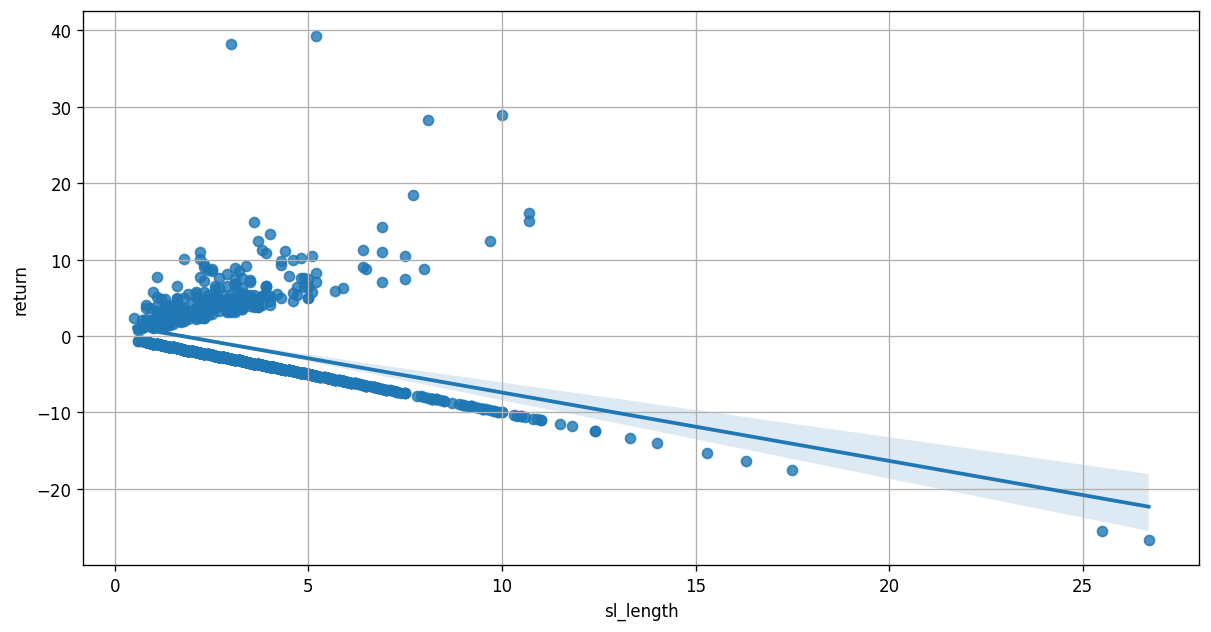

In [52]:
sns.regplot(x=long['sl_length'], y=long['return'])
plt.grid(True)

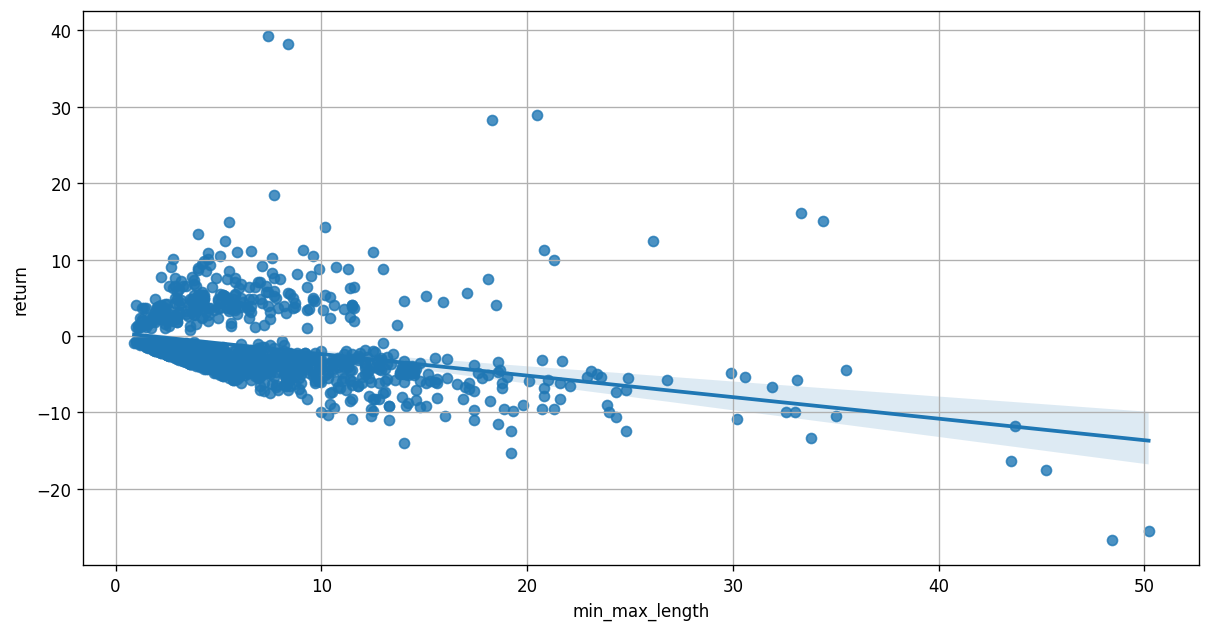

In [53]:
sns.regplot(x=long['min_max_length'], y=long['return'])
plt.grid(True)

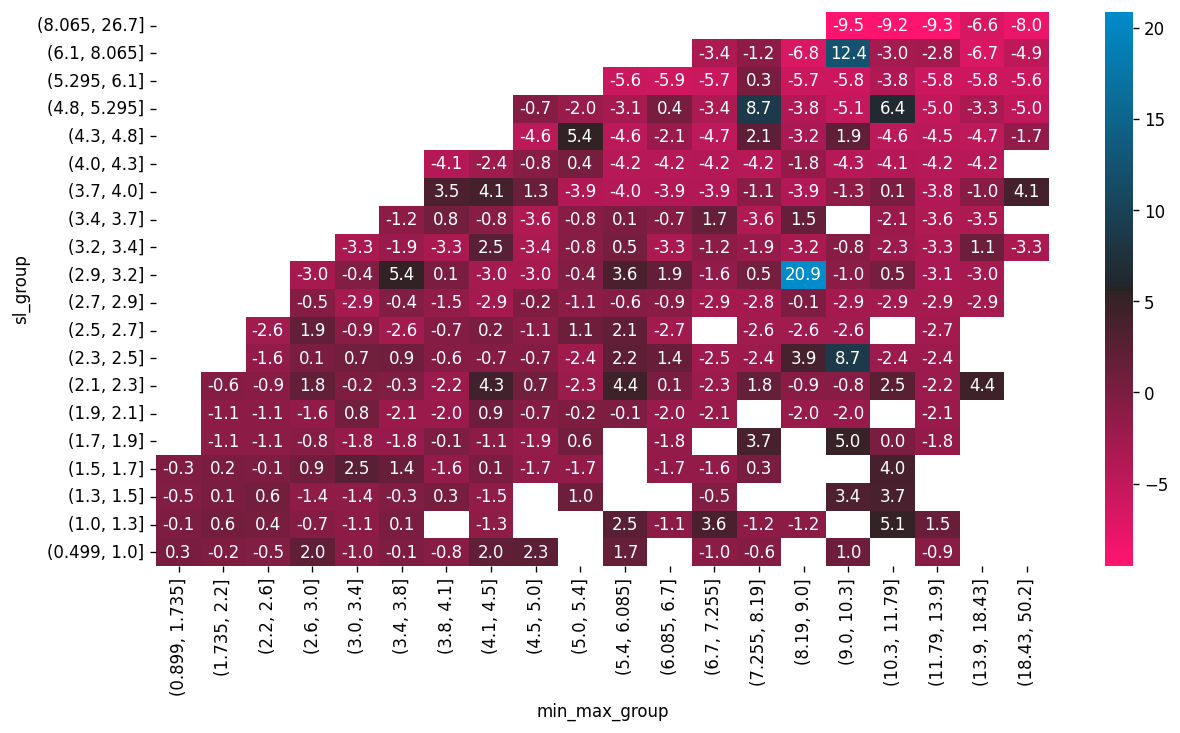

In [54]:
grpd = long.groupby(['sl_group', 'min_max_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='sl_group', columns='min_max_group', values='return').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");